# HOMEWORK PART 3b

---

## Part 2: See if you can train your NN to identify (for ρ = 28) when a transition from one lobe to another is imminent. Determine how far in advance you can make this prediction. (NOTE: you will have to label the transitions in a test set in order to do this task).

In [1]:
#%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm, rc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import os

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

#! pip install pyrenn
import pyrenn as prn

rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

In [24]:
def count_time_swap(V, x):
    """Generate input data to train a neural network able to
    predict time befor swap.
    
    Parameters
    ----------
    V : array
        Right singular vectors of the SVD applied to time-delayed 
        embedding of the x coordinate.

    Returns
    -------
    X_train : array
        Input matrix for training the neural network.

    """ 
    V1 = V[None, :, 0]
    Vend = V[None, :, -1]
    
    x0 = V1[0, 0] # initial condition
    t_forecast = np.zeros_like(V1)
    label1 = 1 if x0 > 0 else -1
    t_count = 0
    pos = 0
    for i in range(1, V1.shape[1]):
        t_count += 1
        if np.sign(V1[0, i]) != label1:
            t_forecast[0, pos] = t_count
            t_count = 0
            pos = i
            label1 = np.sign(V1[0, i])
    X_train = np.vstack((V1, Vend, t_forecast))
    
    return X_train

In [3]:
def Lorenz(x, t, dummy, sigma, b, r):
    """Lorenz equations
    
    Parameters
    ----------
    t : array
        Discretization in time.
    x0 : array
        Initial conditions.
    b, p, d, r : float
        Parameters.

    Returns
    -------
    rhs : array
       Integration of the state.
    """
    
    x1, x2, x3 = x
    
    rhs = [sigma * (x2 - x1),
           r * x1 - x2 - x1 * x3,
           x1 * x2 - b * x3]
    return rhs

In [60]:
seed = 123
dt = 0.01
final_t = 15
n = int(final_t / dt) + 1
t = np.linspace(0, final_t, n)

beta = 8/3
sigma = 10
rho = [10, 15, 20, 25, 30, 35, 40]
x0 = [5, 5, 5]
n_emb = 10

X_train, y_train = np.empty((0,4)), np.empty((0,3))
X_val, y_val = np.empty((0,4)), np.empty((0,3))
X_test, y_test = np.empty((0,4)), np.empty((0,3))

for _rho in rho:
    # Integration of the dynamics
    lor = odeint(Lorenz, x0, t, args=([], sigma, beta, _rho), mxstep=10**8) # integrate PDE
    x = np.reshape(lor[:, 0], (-1, 1))
    # Time-delay embedding
    vv = x[:-(n_emb)]
    for i in range(n_emb-1):
        vv = np.hstack((vv, x[i+1:-n_emb+i+1]))
    # SVD
    U, S, V = np.linalg.svd(vv.T, full_matrices=True) # economy SVD
    # Lobe jump count
    xx = count_time_swap(x, V)
    # Data sets creation
    param = np.ones_like(xx[None, 0, :]) * _rho
    data = np.hstack((xx.T, param.T))
    X = data[:-1, :]
    y = data[1:, :-1]
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = np.append(X_train, _X_train, axis=0)
    y_train = np.append(y_train, _y_train, axis=0)
    X_val = np.append(X_val, _X_val, axis=0)
    y_val = np.append(y_val, _y_val, axis=0)
    X_test = np.append(X_test, _X_test, axis=0)
    y_test = np.append(y_test, _y_test, axis=0)

In [66]:
epochs = 100
net_LM = prn.CreateNN([4,100,100,100,3])
net_LM = prn.train_LM(X_train.T, y_train.T, net_LM, verbose=True, k_max=epochs, E_stop=1e-5)

pyrenn.saveNN(net, filename)
pyrenn.loadNN(filename)

Iteration:  0 		Error:  43087.45906845905 	scale factor:  3.0


KeyboardInterrupt: 

In [ ]:
torch.save(model1.state_dict(), 'weights_NN')

In [30]:
n_emb = 20
vv = x[:-(n_emb)]
for i in range(n_emb-1):
    vv = np.hstack((vv, x[i+1:-n_emb+i+1]))

UU, SS, VV = np.linalg.svd(vv.T, full_matrices=True) # economy SVD
r = 10 # number of modes
U = UU.T[:, 0:r]
S = SS[0:r]
V = VV.T[:, 0:r]

In [41]:
xx = count_time_swap(x, V)
xx.shape, len(x[2, :]), tt

((3, 1501), 1, 5.318890739925115)

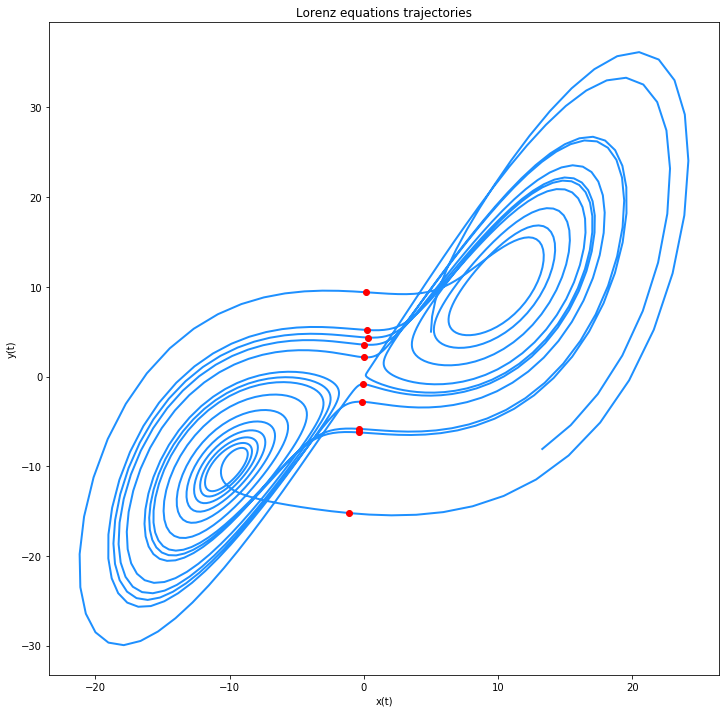

In [49]:
fig3 = plt.figure(figsize=(12, 12))
ax = fig3.gca()
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
plt.title('Lorenz equations trajectories')
ax.plot(x[:, 0], y[:, 0], linewidth='2', color='dodgerblue')
for i in range(xx.shape[1]):
    if xx[2, i] != 0:
        tt = int(i + xx[2, i])
        ax.plot(x[tt, 0], y[tt, 0], 'or', linewidth='2')